In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [37]:
# import data
brca_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
og_rna_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
rnaseq_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/TCGA_BRCA_ExprDeconvolution_training.csv',  index_col=0)
rnaseq_df.head


<bound method NDFrame.head of                                  NOC2L  PLEKHN1     HES4     ISG15       AGRN  \
TCGA-3C-AAAU-01A-11R-A41B-07  7014.780  735.864  218.180   792.460  14311.184   
TCGA-3C-AALI-01A-11R-A41B-07  1869.260  149.212  333.760   792.168   2853.296   
TCGA-3C-AALK-01A-11R-A41B-07  3722.696  858.212  686.360   849.168  13086.220   
TCGA-A1-A0SE-01A-11R-A084-07  3380.752  150.696   68.580   320.296  11528.724   
TCGA-A1-A0SF-01A-11R-A144-07  4120.980  343.252   54.152   301.516  10883.852   
...                                ...      ...      ...       ...        ...   
TCGA-E2-A2P5-01A-11R-A19W-07  4423.836  321.508  197.328   968.792   8066.548   
TCGA-AC-A2FE-01A-11R-A19W-07  1820.324  114.816  127.468  1760.508   5137.288   
TCGA-EW-A3E8-01B-11R-A24H-07  5453.568  772.756  611.776  5520.484  13198.048   
TCGA-D8-A3Z5-01A-41R-A24H-07  5669.208  477.080  794.992   692.900  18635.616   
TCGA-A8-A08C-01A-11R-A00Z-07  3901.620  342.412  120.664   697.832  10200.500  

In [38]:
import pandas as pd

def match_case_ids(df1, df2):
    """
    Modify df2's index to match df1's Case ID format and compare them
    
    Parameters:
    df1: First dataframe with Case ID column
    df2: Second dataframe with TCGA sample IDs as index
    
    Returns:
    tuple: (modified df2, boolean mask of matching indices)
    """
    # Extract Case IDs from df1
    case_ids_df1 = df1['Case ID'].unique()
    
    # Convert df2's index to match Case ID format
    # Current format: TCGA-XX-XXXX-01X-XXR-XXXX-XX
    # Target format: TCGA-XX-XXXX
    new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]
    
    # Create a copy of df2
    df2_modified = df2.copy()
    
    # Reset the index to default numeric index and add Case ID as a column
    df2_modified = df2_modified.reset_index(drop=True)
    df2_modified.insert(0, 'Case ID', new_case_ids)
    
    # Check which case IDs match
    matching_cases = df2_modified['Case ID'].isin(case_ids_df1)
    
    # Print summary statistics
    print(f"Total cases in df1: {len(case_ids_df1)}")
    print(f"Total cases in df2: {len(df2_modified)}")
    print(f"Number of matching cases: {matching_cases.sum()}")
    print(f"Number of non-matching cases: {(~matching_cases).sum()}")
    
    return df2_modified, matching_cases

# Example usage:
# df2_modified, matches = match_case_ids(df1, df2)

# To see non-matching cases:
# non_matching_df2 = df2_modified[~matches]
# non_matching_df1 = df1[~df1['Case ID'].isin(df2_modified['Case ID'])]

<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_7912/2366072738.py:20: SyntaxWarning: invalid escape sequence '\w'
  new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]


In [39]:
og_rna_df_z = og_rna_df.copy()
rnaseq_df_z = rnaseq_df.copy()

df2_modified, matches = match_case_ids(og_rna_df_z, rnaseq_df_z)


Total cases in df1: 1095
Total cases in df2: 622
Number of matching cases: 622
Number of non-matching cases: 0


In [40]:
 # Rename the index to 'Case ID'
df2_modified.head()


,Case ID,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
0,TCGA-3C-AAAU,7014.780,735.864,218.180,792.460,14311.184,534.604,1165.740,1706.192,8600.396,...,4135.352,899.236,4764.276,4872.996,351.604,1424.376,4952.292,3316.272,23.848,5001.188
1,TCGA-3C-AALI,1869.260,149.212,333.760,792.168,2853.296,46.708,265.304,195.200,2310.480,...,5018.776,283.844,2170.252,1038.396,151.324,590.240,898.484,1542.276,79.496,2060.468
2,TCGA-3C-AALK,3722.696,858.212,686.360,849.168,13086.220,713.896,914.300,639.528,4446.440,...,7463.896,307.776,1845.476,978.900,228.900,442.792,1172.336,1388.096,132.076,3006.012
3,TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
4,TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544


In [41]:

rnaseq_df = df2_modified

In [42]:

# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)


Number of common samples: 571
rnaseq_df_common: (571, 9854)
brca_df_common: (571, 41)


In [43]:
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

Duplicate Case IDs in rnaseq_df: 0

After removing duplicates:
rnaseq_df_common: (571, 9854)
brca_df_common: (571, 41)

Samples match: True
Number of samples in each: 571 571


,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [44]:

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)



Indices match exactly: True


In [45]:
print(brca_df_common.shape)
brca_df_common.head()

(571, 41)


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC,HRD_status_base,HRD_adjust,soft_prob,Confidence
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,6,6,1,13,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.13875,0.032295
TCGA-A1-A0SF,7,11,8,26,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.48000,0.310026
TCGA-A1-A0SG,3,2,4,9,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP,0.00000,0.014774
TCGA-A1-A0SH,8,13,13,34,somatic.nonsense,germline.null_or_pathogenic,0.0,0,0,0,...,0,0,0,YES,LumA,0,HR,HRD ambiguous,0.52000,0.689974
TCGA-A1-A0SJ,9,17,3,29,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.49875,0.450166


In [46]:
print(rnaseq_df_common.shape)
rnaseq_df_common.head()

(571, 9853)


,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [47]:
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/deseq_bottom_2_percent.tsv', sep = '\t', index_col=0)



deseq_results.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000163975.12|MELTF|protein_coding,4.223192,2.197306,0.122265,17.971715,3.245282e-72,6.764141e-68
ENSG00000115163.15|CENPA|protein_coding,4.405742,1.489792,0.087457,17.034565,4.551128e-65,4.742959e-61
ENSG00000107937.19|GTPBP4|protein_coding,13.539092,0.820738,0.048266,17.004536,7.600421e-65,5.280519e-61
ENSG00000136943.11|CTSV|protein_coding,2.170985,1.952020,0.120999,16.132475,1.508526e-58,7.860554e-55
ENSG00000140545.15|MFGE8|protein_coding,31.920965,1.701760,0.106421,15.990768,1.481928e-57,6.177567e-54


In [48]:

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()

(571, 0)


""
Case ID
TCGA-A1-A0SE
TCGA-A1-A0SF
TCGA-A1-A0SG
TCGA-A1-A0SH
TCGA-A1-A0SJ


In [49]:
rnaseq_df_common.head()
rnaseq_df_top_genes = rnaseq_df_common

In [50]:
rnaseq_df_top_genes.head()

,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [51]:
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)


(571, 9853)
(571, 0)
(571, 41)


In [52]:
brca_df_common['Confidence'].value_counts()

Confidence
0.014774    22
0.012128    17
0.005486    17
0.026597    17
0.006693    16
            ..
0.997975     1
0.999991     1
0.999989     1
0.942676     1
0.999975     1
Name: count, Length: 88, dtype: int64

In [53]:
brca_df_common['HRD_status_base'].value_counts()

HRD_status_base
HR     436
HRD    135
Name: count, dtype: int64

In [54]:
brca_df_common.columns

Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC', 'HRD_status_base', 'HRD_adjust',
       'soft_prob', 'Confidence'],
      dtype='object')

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score, f1_score, recall_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


Training models on expression deconvolution genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


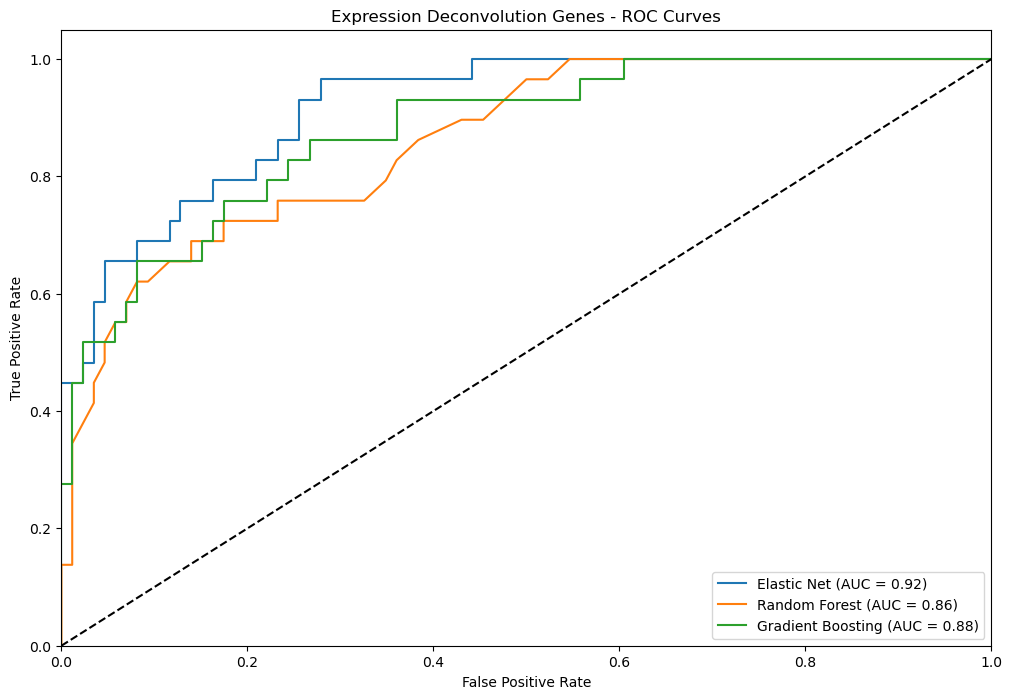

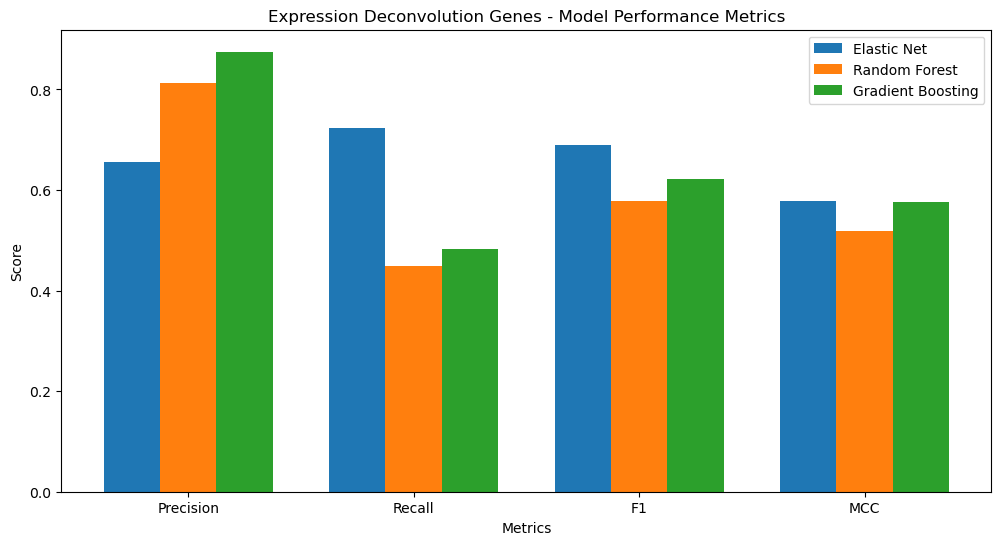

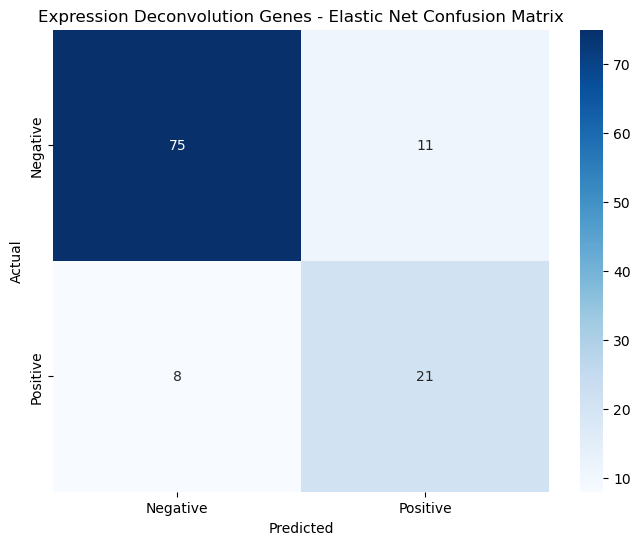

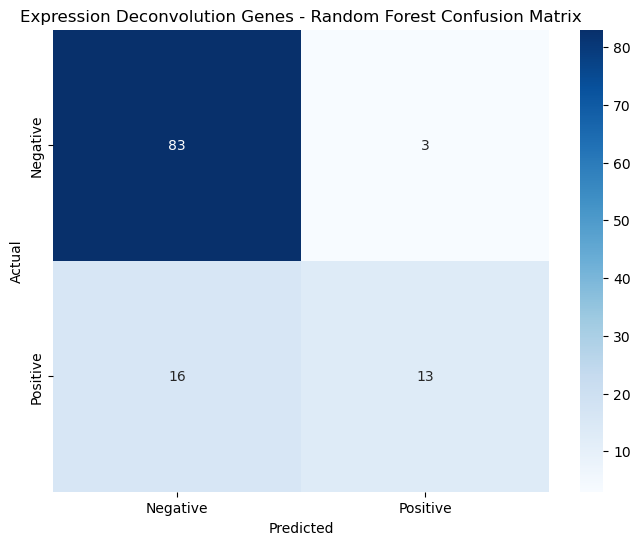

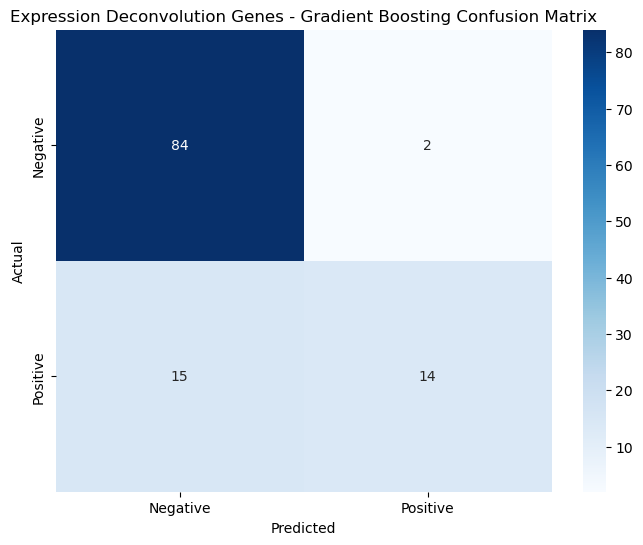


Results for Expression Deconvolution:

Elastic Net:
Precision: 0.656
Recall: 0.724
F1: 0.689
MCC: 0.578
AUC: 0.918

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        86
           1       0.66      0.72      0.69        29

    accuracy                           0.83       115
   macro avg       0.78      0.80      0.79       115
weighted avg       0.84      0.83      0.84       115


Random Forest:
Precision: 0.812
Recall: 0.448
F1: 0.578
MCC: 0.519
AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        86
           1       0.81      0.45      0.58        29

    accuracy                           0.83       115
   macro avg       0.83      0.71      0.74       115
weighted avg       0.83      0.83      0.82       115


Gradient Boosting:
Precision: 0.875
Recall: 0.483
F1: 0.622
MCC: 0.577
AUC: 0.879

Classification Repo

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report,
                           precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(X, y, task='classification'):
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Classification Report': classification_report(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        metrics['ROC'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}
    
    return metrics

def plot_metrics(results, title_prefix=""):
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    for name, metrics in results.items():
        roc = metrics['ROC']
        plt.plot(roc['fpr'], roc['tpr'], 
                label=f'{name} (AUC = {roc["auc"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

    # Plot other metrics as bar chart
    metrics_to_plot = ['Precision', 'Recall', 'F1', 'MCC']
    metrics_data = {
        name: [metrics[m] for m in metrics_to_plot] 
        for name, metrics in results.items()
    }
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    for i, (model_name, values) in enumerate(metrics_data.items()):
        plt.bar(x + i*width, values, width, label=model_name)
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'{title_prefix} Model Performance Metrics')
    plt.xticks(x + width, metrics_to_plot)
    plt.legend()
    plt.show()

    # Plot confusion matrices
    for name, metrics in results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'{title_prefix} {name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate all metrics
        results[name] = calculate_metrics(y_test, y_pred, y_pred_proba)
    
    return results

def main():
    # For top 2% expressed genes
    print("Training models on expression deconvolution genes:")
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['HRD_status_base']
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    plot_metrics(results_top, "Expression Deconvolution Genes -")
    
    
    # Print detailed results
    for dataset_name, results in [("Expression Deconvolution", results_top)]:
        print(f"\nResults for {dataset_name}:")
        for model_name, metrics in results.items():
            print(f"\n{model_name}:")
            print(f"Precision: {metrics['Precision']:.3f}")
            print(f"Recall: {metrics['Recall']:.3f}")
            print(f"F1: {metrics['F1']:.3f}")
            print(f"MCC: {metrics['MCC']:.3f}")
            print(f"AUC: {metrics['ROC']['auc']:.3f}")
            print("\nClassification Report:")
            print(metrics['Classification Report'])

if __name__ == "__main__":
    main()

/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


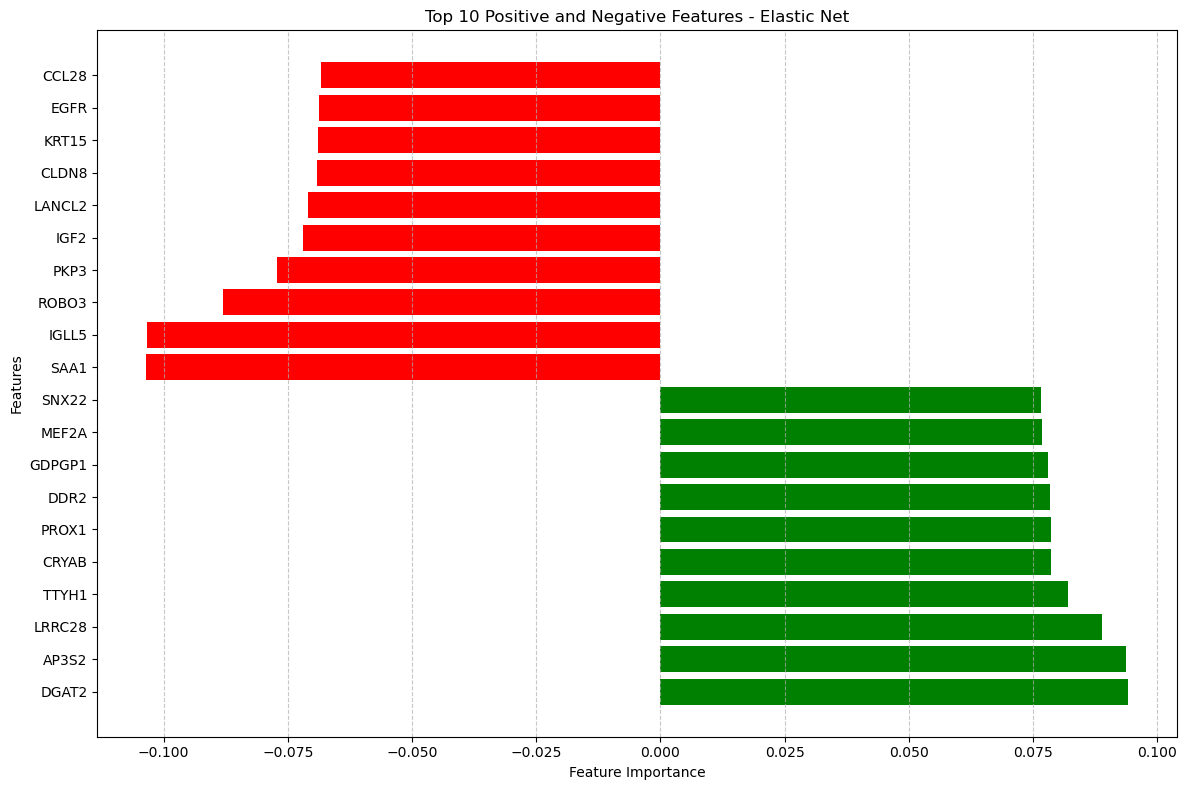


Top Features for Elastic Net:

Positive Features (Top 10):
feature  importance
  DGAT2    0.094186
  AP3S2    0.093620
 LRRC28    0.088819
  TTYH1    0.082086
  CRYAB    0.078554
  PROX1    0.078517
   DDR2    0.078321
 GDPGP1    0.078082
  MEF2A    0.076846
  SNX22    0.076645

Negative Features (Top 10):
feature  importance
   SAA1   -0.103436
  IGLL5   -0.103415
  ROBO3   -0.087969
   PKP3   -0.077070
   IGF2   -0.071852
 LANCL2   -0.070934
  CLDN8   -0.069119
  KRT15   -0.069003
   EGFR   -0.068730
  CCL28   -0.068286




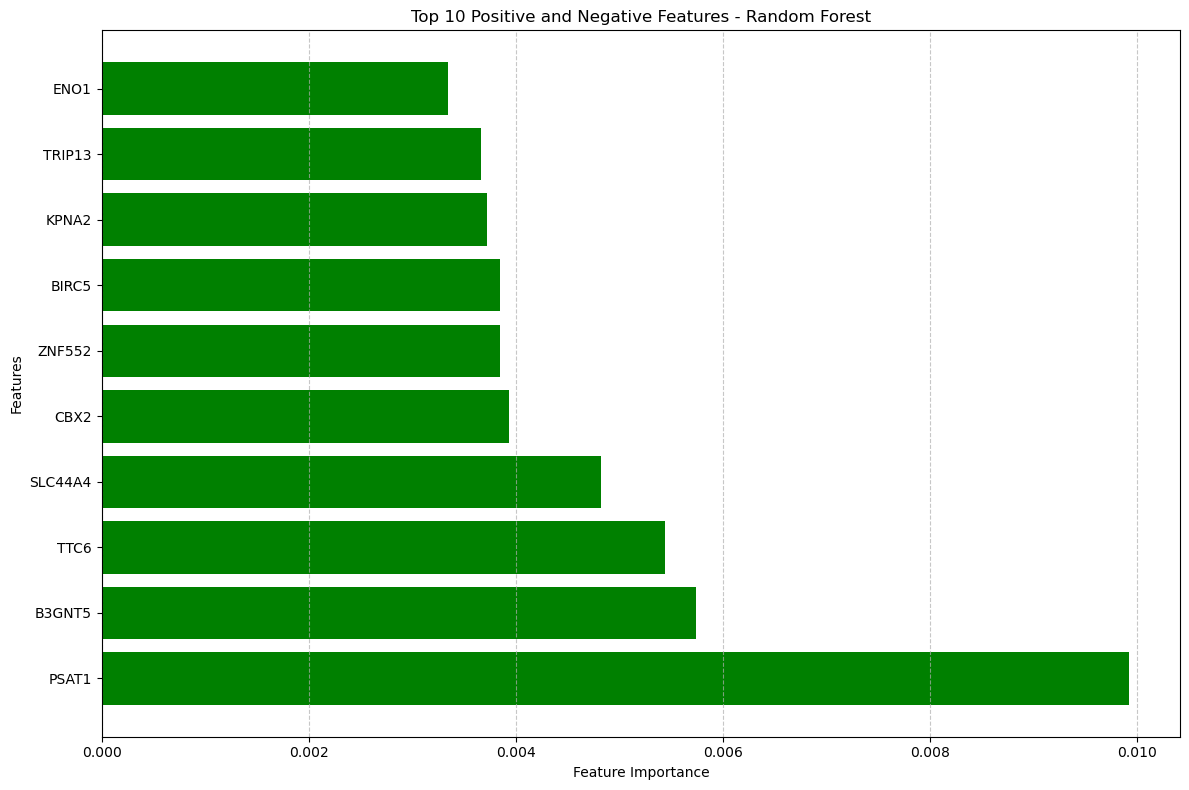


Top Features for Random Forest:

Positive Features (Top 10):
feature  importance
  PSAT1    0.009918
 B3GNT5    0.005743
   TTC6    0.005443
SLC44A4    0.004818
   CBX2    0.003936
 ZNF552    0.003845
  BIRC5    0.003845
  KPNA2    0.003722
 TRIP13    0.003668
   ENO1    0.003340

Negative Features (Top 10):
Empty DataFrame
Columns: [feature, importance]
Index: []




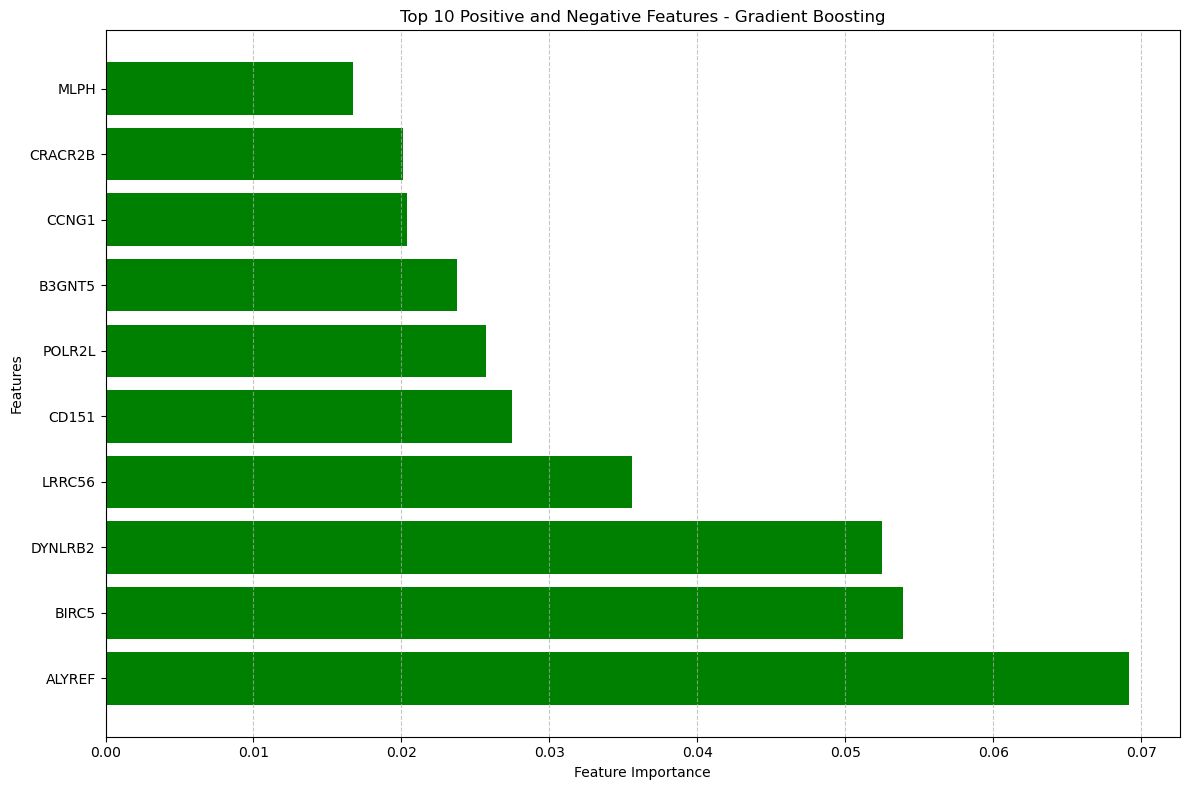


Top Features for Gradient Boosting:

Positive Features (Top 10):
feature  importance
 ALYREF    0.069160
  BIRC5    0.053876
DYNLRB2    0.052482
 LRRC56    0.035570
  CD151    0.027503
 POLR2L    0.025747
 B3GNT5    0.023725
  CCNG1    0.020360
CRACR2B    0.020102
   MLPH    0.016732

Negative Features (Top 10):
Empty DataFrame
Columns: [feature, importance]
Index: []




In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importance(model, feature_names, model_name):
    if model_name == 'Elastic Net':
        # For logistic regression, use coefficients
        importance = model.coef_[0]
    elif model_name in ['Random Forest', 'Gradient Boosting']:
        # For tree-based models, use feature importances
        importance = model.feature_importances_
        
    # Create DataFrame with feature names and importance scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    
    # Sort by absolute importance to get both positive and negative top features
    feature_importance['abs_importance'] = abs(feature_importance['importance'])
    feature_importance = feature_importance.sort_values('abs_importance', ascending=False)
    
    # Get top 10 positive and negative features
    top_positive = feature_importance[feature_importance['importance'] > 0].head(10)
    top_negative = feature_importance[feature_importance['importance'] < 0].head(10)
    
    return pd.concat([top_positive, top_negative])

def plot_top_features(top_features, model_name):
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    colors = ['green' if x > 0 else 'red' for x in top_features['importance']]
    bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)
    
    # Customize plot
    plt.title(f'Top 10 Positive and Negative Features - {model_name}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    
    # Add gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

# First train the models
X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
    rnaseq_df_top_genes, brca_df_common['HRD_status_base']
)

# Define and train models
models = {
    'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                    l1_ratio=0.5, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train each model
for name, model in models.items():
    model.fit(X_train_top, y_train_top)

# Get feature names from your dataset
feature_names = rnaseq_df_top_genes.columns.tolist()

# For each model, get and plot top features
for model_name, model in models.items():
    # Get top features
    top_features = get_feature_importance(model, feature_names, model_name)
    
    # Plot features
    plot_top_features(top_features, model_name)
    plt.show()
    
    # Print feature importance values
    print(f"\nTop Features for {model_name}:")
    print("\nPositive Features (Top 10):")
    positive_features = top_features[top_features['importance'] > 0].sort_values('importance', ascending=False)
    print(positive_features[['feature', 'importance']].to_string(index=False))
    
    print("\nNegative Features (Top 10):")
    negative_features = top_features[top_features['importance'] < 0].sort_values('importance')
    print(negative_features[['feature', 'importance']].to_string(index=False))
    print("\n" + "="*50 + "\n")

/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Skipping nan due to insufficient samples or class imbalance


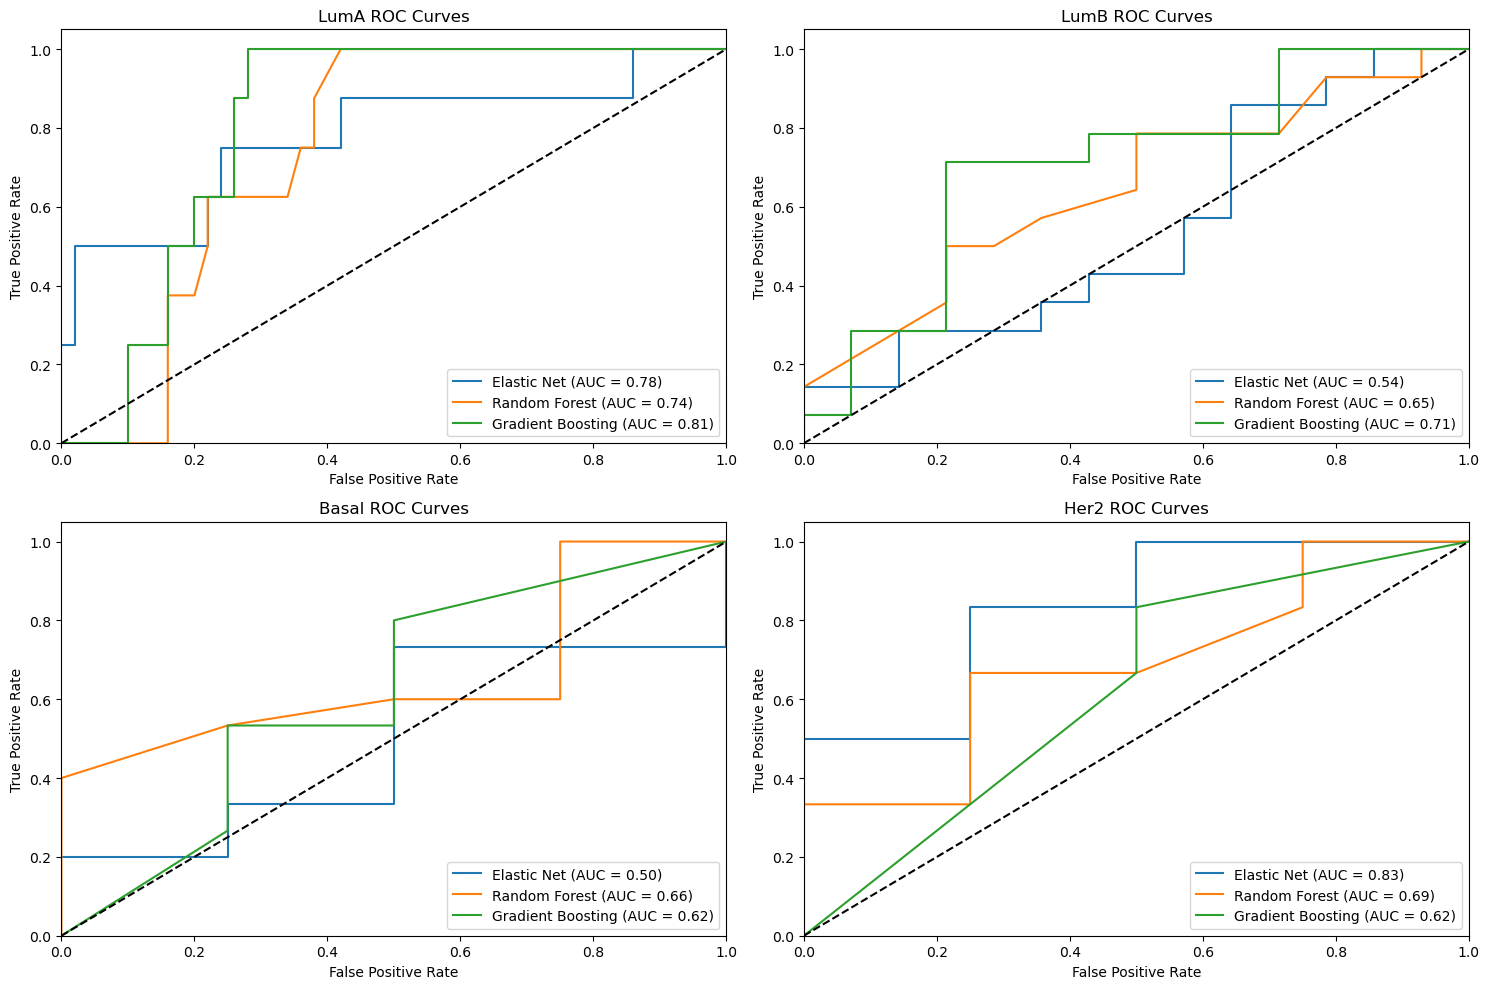

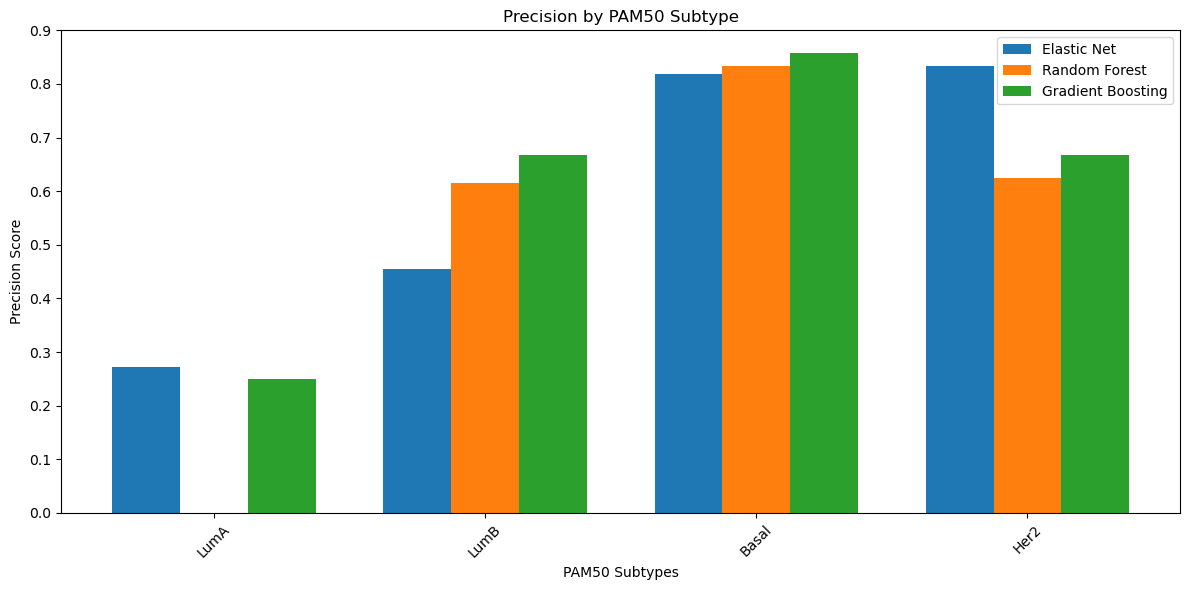

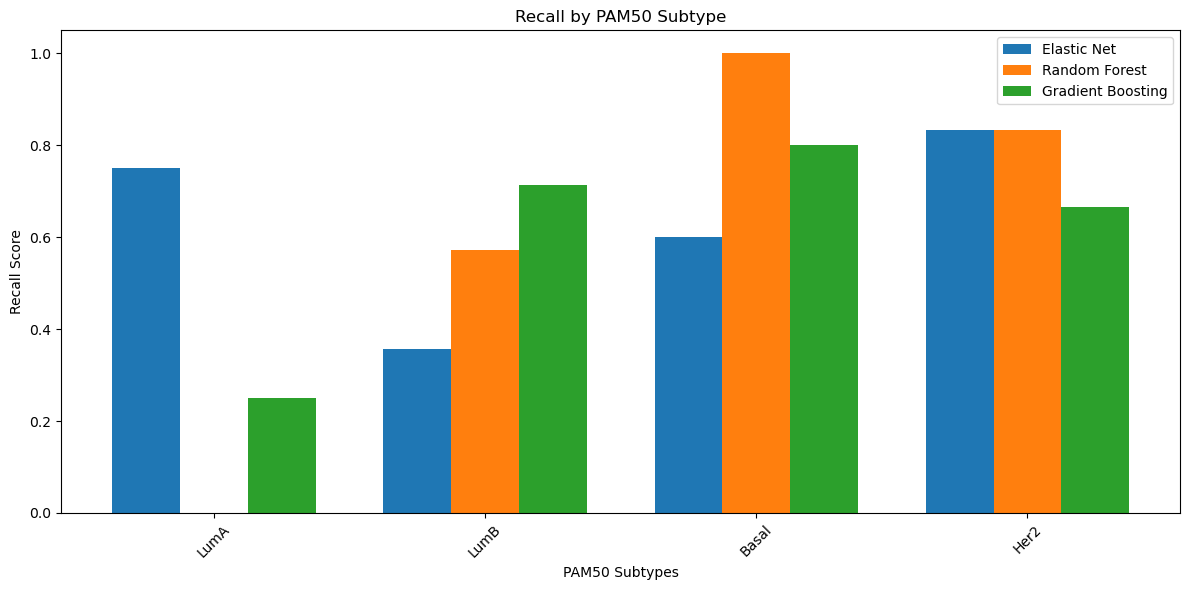

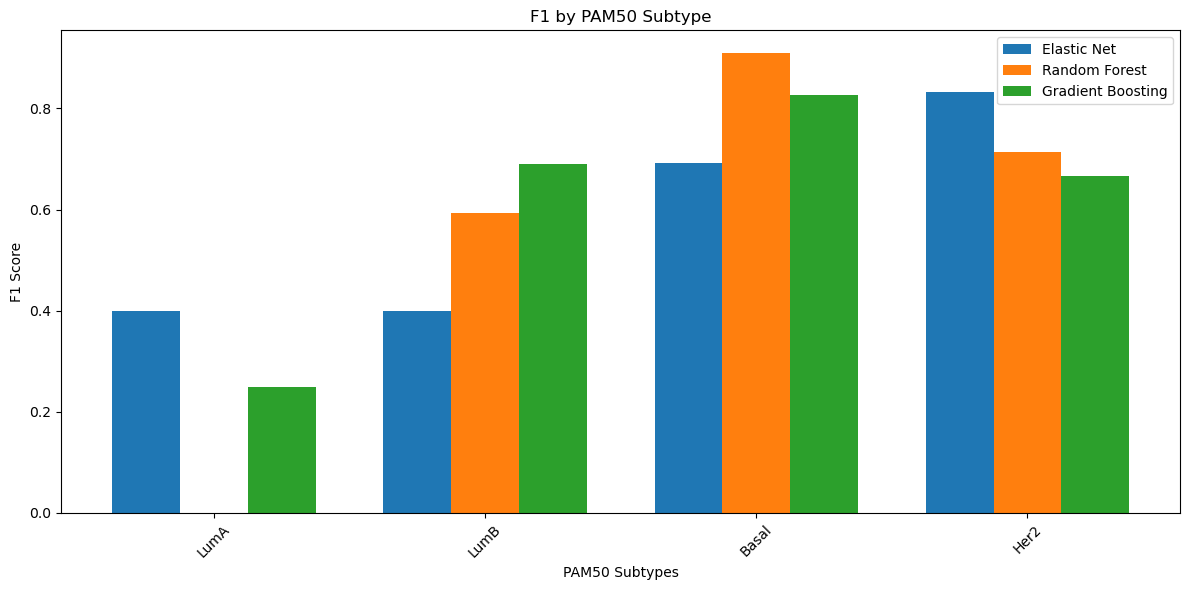

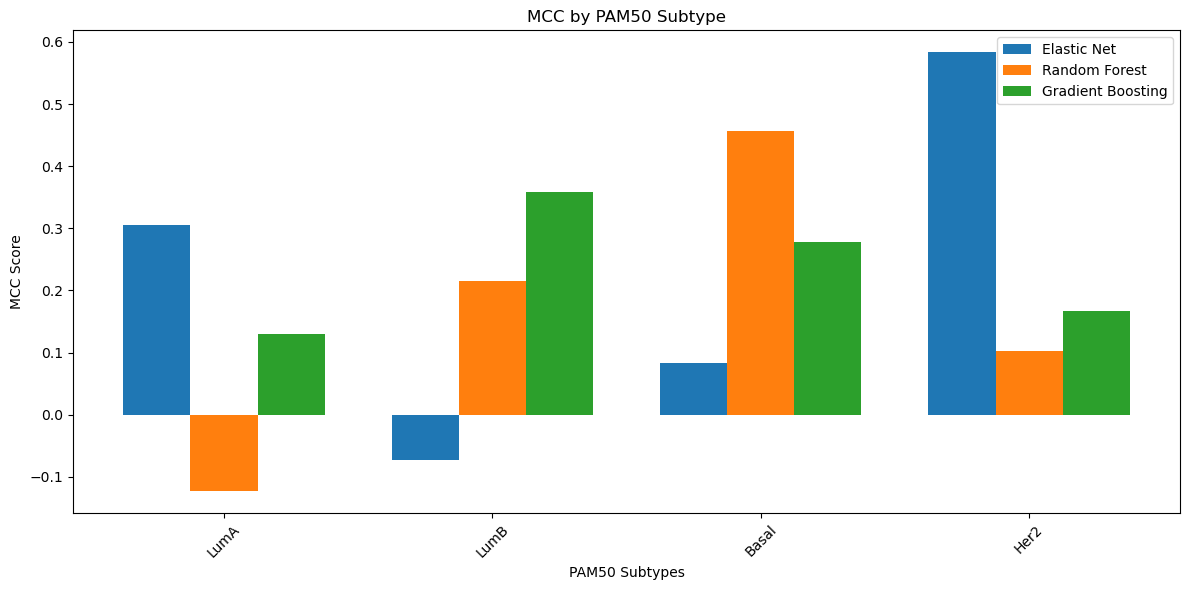


Results for LumA:
Number of samples: 288

Elastic Net:
Precision: 0.273
Recall: 0.750
F1: 0.400
MCC: 0.306
AUC: 0.777

Confusion Matrix:
[[34 16]
 [ 2  6]]

Random Forest:
Precision: 0.000
Recall: 0.000
F1: 0.000
MCC: -0.123
AUC: 0.745

Confusion Matrix:
[[45  5]
 [ 8  0]]

Gradient Boosting:
Precision: 0.250
Recall: 0.250
F1: 0.250
MCC: 0.130
AUC: 0.810

Confusion Matrix:
[[44  6]
 [ 6  2]]

Results for LumB:
Number of samples: 136

Elastic Net:
Precision: 0.455
Recall: 0.357
F1: 0.400
MCC: -0.073
AUC: 0.541

Confusion Matrix:
[[8 6]
 [9 5]]

Random Forest:
Precision: 0.615
Recall: 0.571
F1: 0.593
MCC: 0.215
AUC: 0.648

Confusion Matrix:
[[9 5]
 [6 8]]

Gradient Boosting:
Precision: 0.667
Recall: 0.714
F1: 0.690
MCC: 0.358
AUC: 0.709

Confusion Matrix:
[[ 9  5]
 [ 4 10]]

Results for Basal:
Number of samples: 93

Elastic Net:
Precision: 0.818
Recall: 0.600
F1: 0.692
MCC: 0.083
AUC: 0.500

Confusion Matrix:
[[2 2]
 [6 9]]

Random Forest:
Precision: 0.833
Recall: 1.000
F1: 0.909
MCC: 0

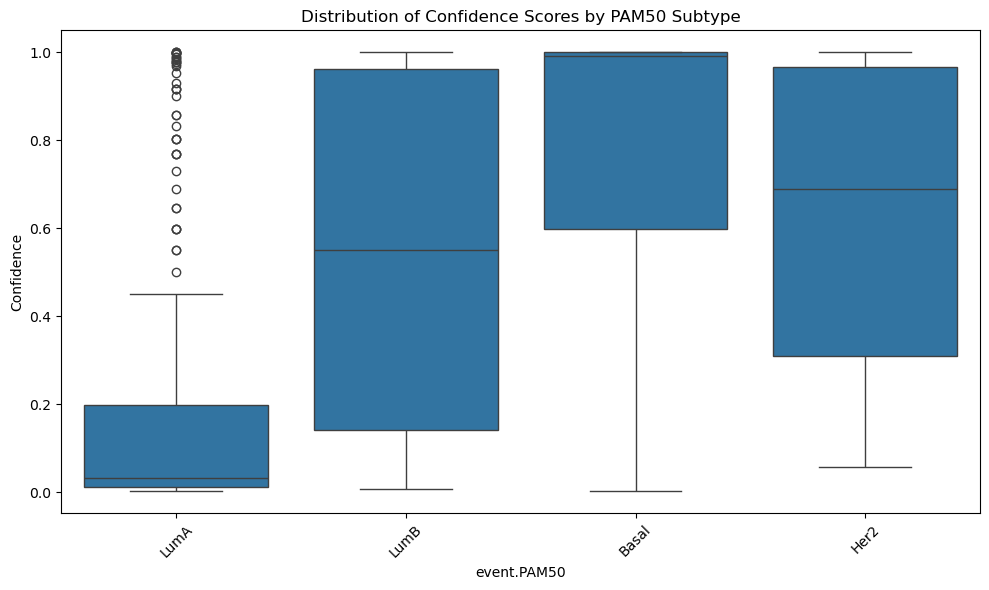

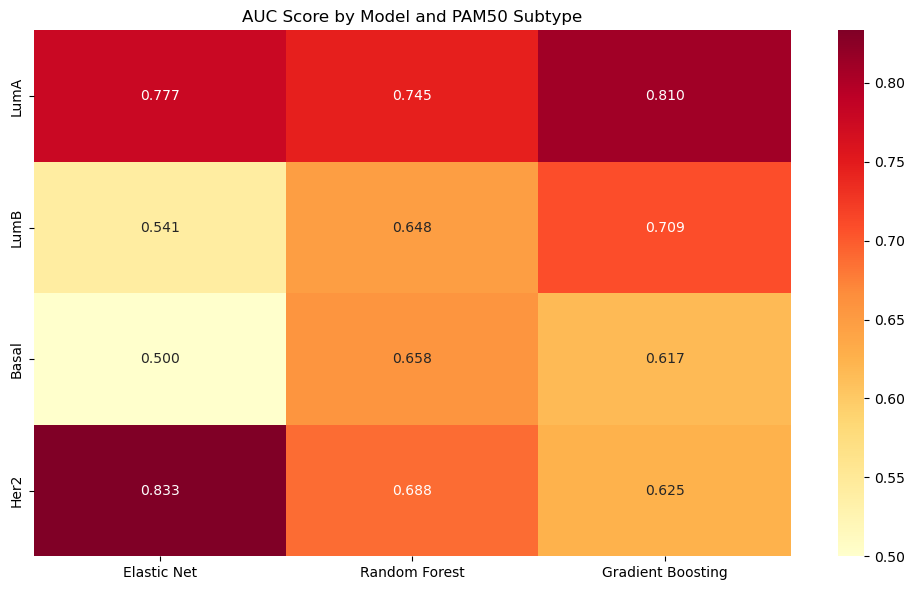

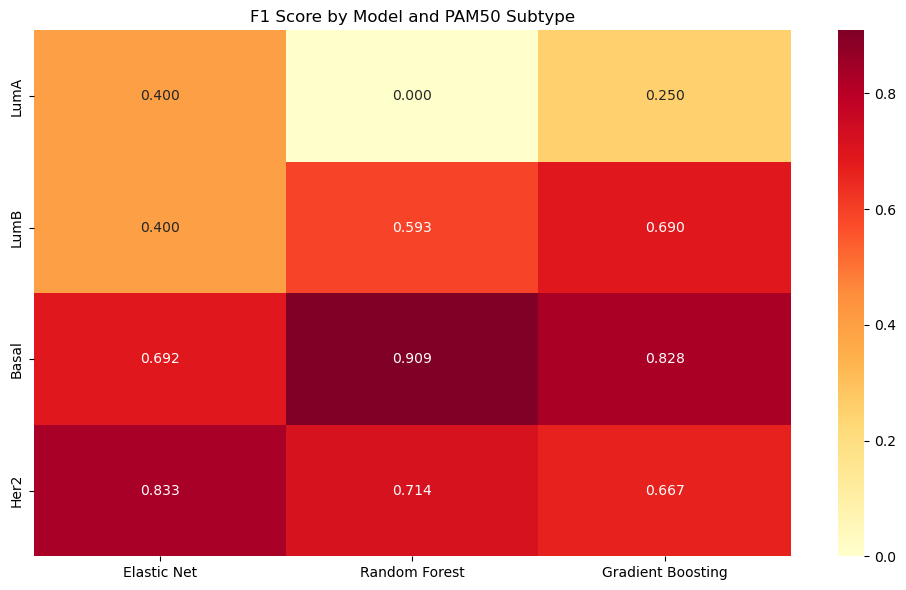

In [ ]:
# Prepare data with binary confidence classes
confidence_threshold = 0.5
y_binary = (brca_df_common['Confidence'] > confidence_threshold).astype(int)

def train_evaluate_by_pam50(X, y, pam50_labels):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    # Split by PAM50 subtype
    pam50_results = {}
    
    for subtype in pam50_labels.unique():
        # Get indices for this subtype
        subtype_mask = (pam50_labels == subtype)
        X_subtype = X[subtype_mask]
        y_subtype = y[subtype_mask]
        
        # Only proceed if we have enough samples
        if len(np.unique(y_subtype)) < 2 or sum(subtype_mask) < 10:
            print(f"Skipping {subtype} due to insufficient samples or class imbalance")
            continue
            
        # Split and scale data
        X_train, X_test, y_train, y_test = train_test_split(
            X_subtype, y_subtype, test_size=0.2, random_state=42, stratify=y_subtype
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate models
        subtype_results = {}
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
            subtype_results[name] = metrics
            
        pam50_results[subtype] = subtype_results
    
    return pam50_results

# Train and evaluate models for each PAM50 subtype
results = train_evaluate_by_pam50(rnaseq_df_top_genes, y_binary, brca_df_common['event.PAM50'])

# Plot ROC curves for each PAM50 subtype
plt.figure(figsize=(15, 10))
for i, (subtype, subtype_results) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    for name, metrics in subtype_results.items():
        roc = metrics['ROC']
        plt.plot(roc['fpr'], roc['tpr'], 
                label=f'{name} (AUC = {roc["auc"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{subtype} ROC Curves')
    plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Plot performance metrics for each PAM50 subtype
metrics_to_plot = ['Precision', 'Recall', 'F1', 'MCC']
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    x = np.arange(len(results))
    width = 0.25
    
    for i, model_name in enumerate(['Elastic Net', 'Random Forest', 'Gradient Boosting']):
        values = [results[subtype][model_name][metric] for subtype in results.keys()]
        plt.bar(x + i*width, values, width, label=model_name)
    
    plt.xlabel('PAM50 Subtypes')
    plt.ylabel(f'{metric} Score')
    plt.title(f'{metric} by PAM50 Subtype')
    plt.xticks(x + width, list(results.keys()), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Print detailed results for each subtype
for subtype, subtype_results in results.items():
    print(f"\n{'='*50}")
    print(f"Results for {subtype}:")
    print(f"Number of samples: {sum(brca_df_common['event.PAM50'] == subtype)}")
    
    for model_name, metrics in subtype_results.items():
        print(f"\n{model_name}:")
        print(f"Precision: {metrics['Precision']:.3f}")
        print(f"Recall: {metrics['Recall']:.3f}")
        print(f"F1: {metrics['F1']:.3f}")
        print(f"MCC: {metrics['MCC']:.3f}")
        print(f"AUC: {metrics['ROC']['auc']:.3f}")
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# Plot distribution of confidence scores by PAM50 subtype
plt.figure(figsize=(10, 6))
sns.boxplot(data=brca_df_common, x='event.PAM50', y='Confidence')
plt.title('Distribution of Confidence Scores by PAM50 Subtype')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a heatmap of model performance across subtypes
performance_data = {
    'AUC': np.zeros((len(results), 3)),
    'F1': np.zeros((len(results), 3))
}

for i, subtype in enumerate(results.keys()):
    for j, model in enumerate(['Elastic Net', 'Random Forest', 'Gradient Boosting']):
        performance_data['AUC'][i, j] = results[subtype][model]['ROC']['auc']
        performance_data['F1'][i, j] = results[subtype][model]['F1']

for metric, data in performance_data.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, 
                annot=True, 
                fmt='.3f',
                xticklabels=['Elastic Net', 'Random Forest', 'Gradient Boosting'],
                yticklabels=list(results.keys()),
                cmap='YlOrRd')
    plt.title(f'{metric} Score by Model and PAM50 Subtype')
    plt.tight_layout()
    plt.show()

In [65]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, pearsonr

def extract_elastic_net_coefficients(model, feature_names):
    """Extract non-zero coefficients from the Elastic Net model."""
    coefficients = pd.DataFrame({
        'Gene': feature_names,
        'Coefficient': model.coef_[0]
    })
    return coefficients[coefficients['Coefficient'] != 0].reset_index(drop=True)

def load_and_clean_excel(excel_path):
    """Load and clean the Excel file data with proper error handling."""
    try:
        # Load the Excel file
        table_s4 = pd.read_excel(excel_path, sheet_name='Table S4', skiprows=1)
        
        print("Original columns:", table_s4.columns.tolist())
        
        # Map of expected column names to possible variations
        column_mapping = {
            'Gene': 'Gene',
            'HRD': 'HRD',
            'HR-Proficient': 'HR_proficient'
        }
        
        # Verify all required columns exist in some form
        for expected_col, actual_col in column_mapping.items():
            if actual_col not in table_s4.columns:
                raise KeyError(f"Cannot find column '{actual_col}' in Excel file")
        
        # Rename columns to standardized format
        table_s4 = table_s4.rename(columns={v: k for k, v in column_mapping.items()})
        
        # Remove any rows with missing values in key columns
        table_s4 = table_s4.dropna(subset=['Gene', 'HRD', 'HR-Proficient'])
        
        return table_s4
    
    except Exception as e:
        print(f"Error loading Excel file: {str(e)}")
        print("Available columns:", table_s4.columns.tolist() if 'table_s4' in locals() else "No data loaded")
        raise

def merge_and_compare(elastic_net_df, excel_df):
    """Merge Elastic Net coefficients with Excel data and identify significant differences."""
    try:
        # Verify input dataframes have required columns
        if not all(col in elastic_net_df.columns for col in ['Gene', 'Coefficient']):
            raise KeyError("Elastic Net DataFrame missing required columns")
        if not all(col in excel_df.columns for col in ['Gene', 'HRD', 'HR-Proficient']):
            raise KeyError("Excel DataFrame missing required columns")
        
        # Merge dataframes
        merged_df = pd.merge(elastic_net_df, excel_df, on='Gene', how='inner')
        
        if len(merged_df) == 0:
            print("Warning: No matching genes found after merge")
            return pd.DataFrame()
        
        # Calculate differences
        merged_df['Excel_Difference'] = merged_df['HRD'] - merged_df['HR-Proficient']
        
        # Perform statistical comparison for each gene
        merged_df['T_Statistic'] = np.nan
        merged_df['P_Value'] = np.nan
        
        # Calculate overall correlation
        correlation, p_value = pearsonr(
            merged_df['Coefficient'],
            merged_df['Excel_Difference']
        )
        
        # Add correlation to the dataframe as a single value
        merged_df['Correlation'] = correlation
        merged_df['Correlation_P_Value'] = p_value
        
        # Calculate significance
        merged_df['Significant'] = merged_df['P_Value'] < 0.05
        
        return merged_df, correlation, p_value
    
    except Exception as e:
        print(f"Error in merge_and_compare: {str(e)}")
        raise

def run_analysis(excel_path, elastic_net_model, feature_names):
    """Run the complete analysis workflow with error handling."""
    try:
        # Load and clean Excel data
        print("Loading Excel data...")
        table_s4 = load_and_clean_excel(excel_path)
        
        # Extract coefficients
        print("Extracting Elastic Net coefficients...")
        elastic_net_coefficients = extract_elastic_net_coefficients(elastic_net_model, feature_names)
        
        # Compare with Excel data
        print("Performing comparison...")
        comparison_results, correlation, correlation_p_value = merge_and_compare(
            elastic_net_coefficients, 
            table_s4
        )
        
        # Display summary
        if not comparison_results.empty:
            print("\nAnalysis Results:")
            print(f"Total comparisons: {len(comparison_results):,}")
            print(f"Significant differences: {comparison_results['Significant'].sum():,}")
            print(f"Overall correlation: {correlation:.3f} (p-value: {correlation_p_value:.3e})")
            
            # Display detailed results
            print("\nTop 10 genes by absolute difference:")
            comparison_results['Abs_Difference'] = np.abs(
                comparison_results['Coefficient'] - comparison_results['Excel_Difference']
            )
            
            top_genes = comparison_results.nlargest(10, 'Abs_Difference')
            print("\nTop differences:")
            print(pd.DataFrame({
                'Gene': top_genes['Gene'],
                'Elastic_Net_Coef': top_genes['Coefficient'].round(4),
                'Excel_Diff': top_genes['Excel_Difference'].round(4),
                'Abs_Difference': top_genes['Abs_Difference'].round(4)
            }).to_string(index=False))
            
            # Basic statistics
            print("\nSummary Statistics:")
            print(f"Mean absolute difference: {comparison_results['Abs_Difference'].mean():.4f}")
            print(f"Median absolute difference: {comparison_results['Abs_Difference'].median():.4f}")
            print(f"Standard deviation of differences: {comparison_results['Abs_Difference'].std():.4f}")
        
        return comparison_results
    
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        raise

# Usage example:

excel_path = '../data/13073_2023_1239_MOESM2_ESM.xlsx'
results = run_analysis(excel_path, elastic_net_model, feature_names)


Loading Excel data...
Original columns: ['Gene', 'HRD', 'HR_proficient', 'BRCA1', 'BRCA2', 'HRD_BRCApos', 'HR_BRCA_proficient']
Extracting Elastic Net coefficients...
Performing comparison...

Analysis Results:
Total comparisons: 145
Significant differences: 0
Overall correlation: 0.623 (p-value: 5.488e-17)

Top 10 genes by absolute difference:

Top differences:
  Gene  Elastic_Net_Coef  Excel_Diff  Abs_Difference
 MFGE8            0.0499      1.1410          1.0911
HAPLN3            0.0252      1.1033          1.0780
ALYREF            0.0393      1.1158          1.0765
 TFDP1            0.0169      1.0748          1.0578
 TEX30            0.0360      1.0666          1.0306
 RCCD1            0.0502      1.0640          1.0138
 FOXK2            0.0188      0.9919          0.9731
  PRC1            0.0510      1.0002          0.9492
  MTBP            0.0373      0.9862          0.9489
   PVR            0.0058      0.9423          0.9365

Summary Statistics:
Mean absolute difference: 0.487

In [ ]:
### run model on yashwin's shared_de_genes
### run model on dani's expression deconvolution data
### run model on my own high confidence samples from sigmoid, split 80/20 + ambiguous set all for test/cv
### use pytorch to create a neural network model
### pull in new soft confidence file from yashwin's main branch that has all 857 samples